# Making Predictions from Data
In this workbook we will define and train a model to make predictions. We will use one of the standard Machine Learning Datasets ("Auto-MPG" dataset from UCI https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data).

The Prediction Problem we will aim to solve is to predict the Miles-Per-Gallon we can expect from a vehicle based on some features of the car (such as number of cylinders, age of the car, the weight of the car). It is a toy dataset (but based on real data about cars from the 1970s and 1980s).

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import os__|This is a standard Python library to work with the file system|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import pandas as pd__|Pandas is a library that helps us manipulate tables of data. We import this|
|__import seaborn as sns__|Seaborn is a library that created very useful visualisations|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [16]:
import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

TensorFlow version is  2.0.0-beta1


## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [17]:
def getData():
  data_file = keras.utils.get_file(fname="auto-mpg.data", origin="https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
  # The data has the following coluns
  column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin Country']
  # Read in the file into a Pandas Dataset
  raw_dataset = pd.read_csv(data_file, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
  # We will discard any rows that contain data with missing values
  raw_dataset = raw_dataset.dropna()
  return raw_dataset

def preprocessCategoricalData(data):
    # Use One-Hot-Encoding for categorical data
    origin = data.pop('Origin Country')
    data['USA'] = (origin == 1)*1.0
    data['Europe'] = (origin == 2)*1.0
    data['Japan'] = (origin == 3)*1.0
    return data
    

def splitDataset(dataset):
  # Split the data into Train and Test Sets
  # We randomly select 80% of the records for our Training Dataset
  train_dataset = dataset.sample(frac=0.8,random_state=0)
  # We then use the remaining records as our Test Dataset
  test_dataset = dataset.drop(train_dataset.index)

  # Extract the labels for training and testing
  train_labels = train_dataset.pop('MPG')
  test_labels = test_dataset.pop('MPG')

  return train_dataset, train_labels, test_dataset, test_labels

def displayPairPlots(data, labels):
  dataset = data.copy()
  dataset['MPG'] = labels
  sns.pairplot(dataset, diag_kind="kde")

def norm(x, train_stats):
  return (x - train_stats['mean']) / train_stats['std']

def normaliseData(train_dataset, test_dataset):
  train_stats = train_dataset.describe()
  train_stats = train_stats.transpose() 

  normed_train_data = norm(train_dataset, train_stats)
  normed_test_data = norm(test_dataset, train_stats)

  return normed_train_data, normed_test_data

def plotHistory(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

def displayScatter(expected, predictions):
  plt.scatter(expected, predictions)
  plt.xlabel('True Values [MPG]')
  plt.ylabel('Predictions [MPG]')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  _ = plt.plot([-100, 100], [-100, 100])
  plt.show()


# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

## Download the Auto-MPG dataset
The data we want to use is hosted by UCI and so we have to download it into our workspace before we can use it. We have created a function in _lesson2.py_ to import the data ready for you to use.

In [18]:
raw_dataset = getData()

dataset = raw_dataset.copy()

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin Country
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Data Pre-Processing
Before we make any predictions we need to examine our dataset and see if it is in a good state for predictions.

### Exercise
In the data above we have two types of data:
Numerical Data - data that describes some quantity of measurement
Categorical Data - data that describes belonging to a Category
Which columns do you think are Categorical data?

### Exercise
In the data above we have two types of data:
- Numerical Data - data that describes some quantity of measurement
- Categorical Data - data that describes belonging to a Category

Which columns do you think are Categorical data?

One approach to pre-processing Categorical data is to use an approach called __one-hot-encoding__. This is where we create a Feature for each category and the training sample is allocated to a category by specifying a 1 in the Category Feature that it belongs to and a 0 in each of the others.

Consider the following data:

|Name|Gender|
|---|---|
|Rod|M|
|Jane|F|
|Sally|F|

The feature _Gender_ is categorical, we can _one-hot-encode_ the data as follows:

|Name|Female|Male|
|---|---|---|
|Rod|0|1|
|Jane|1|0|
|Sally|1|0|


In [19]:
# Let's one-hot-encode our categorical data (and drop the original category feature)
dataset = preprocessCategoricalData(dataset)
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## Creating Training and Testing Datasets
Currently all our data is in one set but ideally we want to have the following datasets:

|Data set| Purpose|
|---|---|
|training|We use this to train our model|
|testing|We use this to test our model - this data is never used for training|

In addition, we need to split out our target values (i.e. the values we want to predict).

In [20]:
train_dataset, train_labels, test_dataset, test_labels = splitDataset(dataset)

## Normalise the Data
We have numerical data that has very different ranges; for example compare the values for _Acceleration_ and _Weight_.

Often, having such differing ranges causes problems for machine learning so we __Normalise__ the data; this is a mathematical operation that preserves the relationship between datapoints but brings them into similar ranges

In [21]:
normed_train_data, normed_test_data = normaliseData(train_dataset, test_dataset)

normed_test_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
9,1.483887,1.865988,2.234620,1.018782,-2.530891,-1.604642,0.774676,-0.465148,-0.495225
25,1.483887,1.578444,2.890853,1.925289,-0.559020,-1.604642,0.774676,-0.465148,-0.495225
28,1.483887,1.041693,2.313368,2.063931,1.054328,-1.604642,0.774676,-0.465148,-0.495225
31,-0.869348,-0.789008,-0.259066,-0.903250,-0.559020,-1.332580,-1.286751,-0.465148,2.012852
33,0.307270,0.351586,-0.127819,-0.422150,-0.917542,-1.332580,0.774676,-0.465148,-0.495225


In [22]:
print("Shape of training data {}".format(normed_train_data.shape))
print("Shape of training label {}".format(train_labels.shape))

Shape of training data (314, 9)
Shape of training label (314,)


## Defining our Model
Now that we have the data in reasonable shape we need to define our Deep Learning Model. We will use the __Keras API__ to define a model consisting of a series of __Dense__ layers; these are Full-Connected layers where each unit in the layer is connected to each and every other unit in the next layer.

The layers will be in sequence such that the order we add them will be the order that they are stacked in the Network and all data goes through the layers in sequence.

We start of by defining our model to be a Sequence Model with the following

`model = keras.Sequential()`

We can then add layers to our model using:

`model.add(Dense(units=128, activation = tf.nn.relu))`

where _units_ is the number of units in that layer and _activation_ is the type of activation function the layer will use.
 - Note: we are not covering the details of activation functions in this workshop so just go with the provided activation function.

We can add as many layers as we want and for this initial model we will have 3 layers:
- Input Layer
- 1 Hidden Layer
- 1 Output Layer

Once defined we will _compile_ our model with an _Optimizer_ and _Loss Function_ and we are ready to go.
- Note that in this workshop we will not go into detail about Optimizers and Loss Functions so just go with the provided values.

In [32]:
def create_model():
    model = keras.Sequential()

    # YOUR CHANGES START HERE

    # Input Layer
    model.add( keras.layers.Dense(units=64, activation=tf.nn.relu, input_shape=[9]) )

    # Hidden Layer
    model.add( keras.layers.Dense(units=32, activation=tf.nn.relu) )

    # Output Layer 
    model.add( keras.layers.Dense(1) )


    # We now compile our model with Loss Function and an Optimizer
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=['mean_squared_error', 'mean_absolute_error'])
    return model


model = create_model()
# Display a summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


## Training the model
We are now ready to start training our model to do this we use the _Keras fit_ function, which takes a series of options that control how learning is to progress. 

In our example we are providing the _fit_ function with our training data and our training labels (expected values). 

We are also telling the Fit function to run for 1,000 epochs (iterations) so it will attempt to learn from the data 1,000 times. This is the _epochs_ option.

We are also telling the fit function to take 20% of the training data and use it to validate how well the training is going. What this means is that the _fit_ function will train on 80% of the training data and after each epoch it will assess how well the model is doing against the 20% it has retained (and not trained on).

This is known as _Validation Accuracy_ and is a reasonable measure of how well our model is learning.

In [29]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## Let's see how we have done
The model has trained for 1,000 epochs but how well has it done?

One way is to look at the Errors Levels during Training and Validation; these are the amount by which our model predictions were wrong.


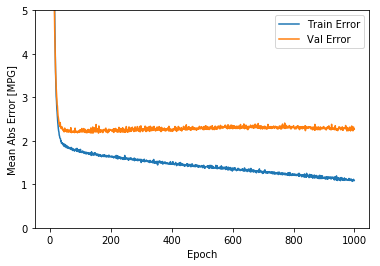

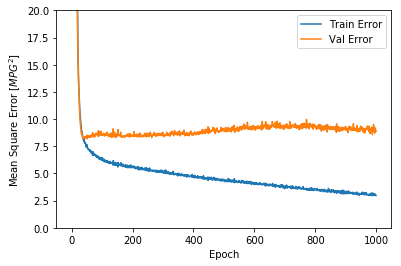

In [30]:
plotHistory(history)

## What's going wrong?
If we look at the graphs we can see that as the number of epochs increases, the difference between the Training and Validation Errors increases.

This is known as __Overfitting__ and is a problem in Machine Learning where a model becomes too good at predicting the values in the Training set and is unable to generalise to values not in the dataset.

For our model to be of any use we want to avoid Overfitting - one appraoch is to stop training earlier - we trained for 1,000 epochs but probably didn't need to.

### Exercise
How many Epochs do you think we should have trained for to produce a __Low__ Validation Loss while minimising the difference between the Training Error and the Validation Error?

## Early Stopping and Overfitting
One approach to overfitting is to stop training soon as it looks like our Validation Loss has stagnated. We could just change the number of _epochs_ but instead we will use a _Keras_ feature that detects this for us and stops the training early.


........................................................................

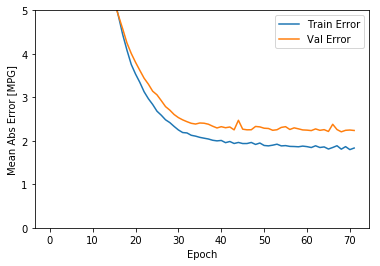

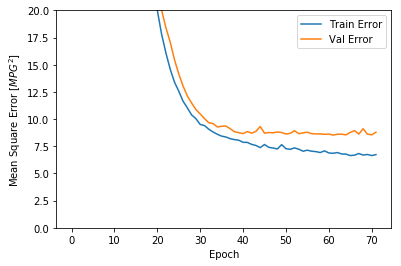

In [34]:
# Create a new instace of our model
model = create_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plotHistory(history)

In [35]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  5.55 MPG


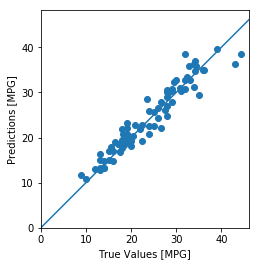

In [36]:
test_predictions = model.predict(normed_test_data).flatten()

displayScatter(test_labels, test_predictions)

### Exercise
Can you improve on this model?

Work in your groups and define a set of model layers; try:
- Models with 1, 2, 3, 4 or 5 Hidden Layers
- Set the number of units in each layer in ascenend, decending and mixed values. For example
    - 32, 64 and 128
    - 128, 64 and 32
    - 128, 32, 64

Then each team member should implement one of the models and train it; once training is complete discuss the following within your team.
 - Which of your models produced the best result?
 - Which models produced the worst results?
 - Based on your results and the models you picked

In [38]:
my_model = keras.Sequential()

# YOUR CHANGES START HERE
# TODO:
#   - Decide how many nodes you want in your input layer (or leave it as is)
#   - Decide how many hidden layers you want in your model
#   - For each layer in your model decide how many nodes and change the value '64' to this value. 
#       Common values are 32, 64, 128, 256

# Input Layer - Todo: if you want to, try changing  the number of units in the input layer
my_model.add(keras.layers.Dense(units=128, activation=tf.nn.relu, input_shape=[9]))

# Hidden Layers - Todo: copy the line below to create additional layers
#                       and update the number of units in each layer
my_model.add(keras.layers.Dense(units=64, activation=tf.nn.relu))

# YOUR CHANGES END HERE

# Output Layer
my_model.add(keras.layers.Dense(1))


# Compile the model
my_model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop(0.001),
                metrics=['mean_absolute_error', 'mean_squared_error'])

my_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________



.........................................

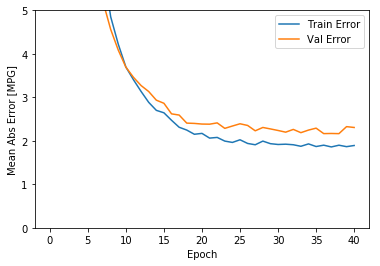

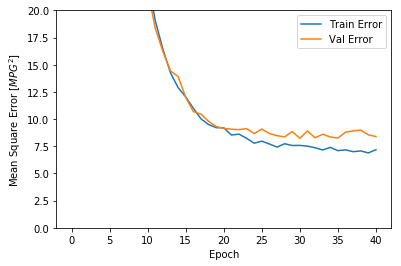

In [39]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = my_model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plotHistory(history)

In [40]:
loss, mae, mse = my_model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.78 MPG


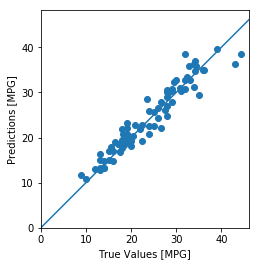

In [41]:
test_predictions = model.predict(normed_test_data).flatten()

displayScatter(test_labels, test_predictions)

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.